In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import os
import asym_funcs as af
import importlib
importlib.reload(af)

<module 'asym_funcs' from '/glade/u/home/lettier/analysis/analysis_antarctic-asym/analysis/asym_funcs.py'>

Read in insolation

In [2]:
ds = xr.open_dataset('we15_runs/daily_insolation_n400_sh.nc')
sh = ds.S.rename({'time':'day'})
sh['day'] = np.arange(1000)

ds = xr.open_dataset('we15_runs/daily_insolation_n400_nh.nc')
nh = ds.S.rename({'t':'day','x':'lat'})
nh['lat'] = sh.lat
nh['day'] = np.arange(1000)

ind = np.append(np.arange(500,1000),np.arange(500))
sh = sh.isel(day=ind)
sh['day'] = np.arange(1000)

Compute annual harmonic at 64.5S

In [4]:
S =  sh.interp(lat=-64.5).values
S1 = np.real(af.get_annual_harmonic(sh.day.values/len(sh.day),S))

In [5]:
print('max annual harmonic {:0.1f}'.format(S1.max()))
print('min annual harmonic {:0.1f}'.format(S1.min()))

max annual harmonic 468.3
min annual harmonic -35.4


In [6]:
# EBM

nt = 1000      # number of timesteps
n  = 400       # number of grid cells
dx = 1.0/n     # grid box width
x = np.arange(dx/2,1+dx/2,dx) # native grid
a0 = 0.7       # ice-free co-albedo at equator
a2 = 0.1       # ice=free co-albedo spatial dependence
aw = a0-a2*x**2  # albedo
alb = xr.DataArray(aw, dims=('lat'), coords = {'lat':np.arcsin(x )*180./np.pi} )
alb_64pt5 = alb.interp(lat = 64.5).values

def vsimplemodel(S):

    alb = alb_64pt5    # albedo at 64.5S
    A = 138.6          # OLR when T = 0 (W m^-2)
    B = 2.1            # OLR temperature dependence (W m^-2 K^-1)
    cw = 9.8           # ocean mixed layer heat capacity (W yr m^-2 K^-1)
    Fb = 5             # heat flux from ocean below (W m^-2)

    dt = 1/nt
    ty = np.arange(dt/2,1+dt/2,dt)

    T = -2 
    Tlist = []
    for year in range(100): # run for 100 years
        for i in range(nt):
            T = T + (dt/cw)*(alb*S[i] - (A+B*T)+Fb)
            Tlist.append(T)

    return np.asarray(Tlist[-nt:])

Solve EBM for T given S, S1

In [7]:
T, T1 = vsimplemodel(S), vsimplemodel(S1) 

In [8]:
def asym_workaround (mydata):
    
    # my normal function doesn't work here as there are minima below nt/2 and above nt/2
    # this is a work around
    mymins =  np.argwhere(mydata<=np.nanmin(mydata))#.mean()
    mymaxs =  np.argwhere(mydata>=np.nanmax(mydata))#.mean()
    mymins = np.where(mymins<nt/2,mymins+nt,mymins)
    dmin = mymins.mean()
    dmax = mymaxs.mean()
   
    a = (dmin-dmax)/1000.
    a = -((a*365.*2.)-365)
    
    return a

Annual mean S 216.46 W/m^2
Annual mean S 216.46 W/m^2


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


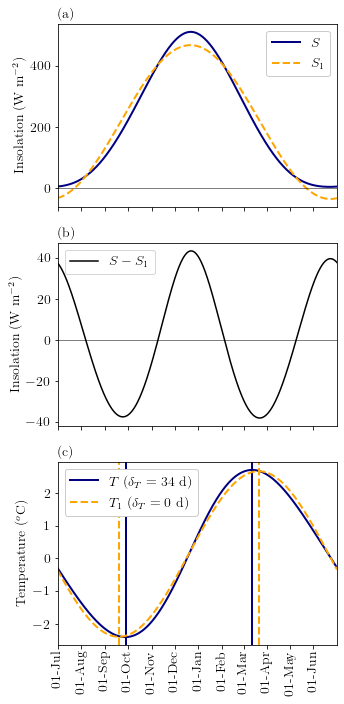

In [9]:
ls = ['-','--','--','-.','-']
colors = ['#000080','orange','tomato','#1b9e77','tomato', '#000080', '#FFA500', 'skyblue','tomato']
fig = plt.figure(figsize=(5,10))
c = ['orange','k','k']

labels = ['$S$','$S_1$']
ax = plt.subplot(3,1,1)
for p, mydata in enumerate([S,S1]):
    print('Annual mean S {:.2f} W/m^2'.format(np.mean(mydata)))
    a = asym_workaround(mydata)
    ax.plot(np.linspace(1,366,len(mydata)),mydata,label=labels[p],c=colors[p],linestyle=ls[p],linewidth=2)

ax.legend(facecolor='white', framealpha=1)
ax.set_title('(a)', loc='left', fontsize=14)
ax.set_ylabel('Insolation (W m$^{-2}$)')
ax.axhline(y=0,c='k',linewidth=.5)
ax.set_xlim([1,366])
ax.set_xticks(af.shfirstofmonthind )
ax.set_xticklabels(['']*12)

ax = plt.subplot(3,1,2)
ax.plot(np.linspace(1,366,len(S1)),(S-S1)[:],c='k',label='$S-S_1$')
ax.set_xlabel('')
ax.set_ylabel('Insolation (W m$^{-2}$)')
ax.axhline(y=0,c='k',linewidth=.5)
ax.set_xlim([1,366])
ax.set_xticks(af.shfirstofmonthind )
ax.set_xticklabels(['']*12)
ax.set_title('(b)', fontsize=14, loc='left')
ax.legend()

labels = ['$T$','$T_1$']
ax = plt.subplot(3,1,3)
for p, mydata in enumerate([T,T1]):
    a, dmax, dmin = af.asym_1d(mydata)
    a = -a/1000.*365.
    if a == 0.:
        label = labels[p]+' ($\delta_T=0$ d)'
    else:
        label=labels[p]+' ($\delta_T= {0}$ d'.format(np.int(np.round(a)))+')'
    ax.plot(np.linspace(1,366,len(mydata)),mydata,label=label,c=colors[p],linestyle=ls[p],linewidth=2)
    ax.axvline(np.linspace(1,366,1000)[int(dmax)],linewidth=2,c=colors[p],linestyle=ls[p])
    ax.axvline(np.linspace(1,366,1000)[int(dmin)],linewidth=2,c=colors[p],linestyle=ls[p])

ax.legend(facecolor='white', framealpha=1)
ax.set_title('(c)', fontsize=14, loc='left')
ax.set_ylabel('Temperature ($^{o}$C)')
ax.set_xlim([1,366])
ax.set_xticks(af.shfirstofmonthind )
ax.set_xticklabels(af.shfirstofmonthlabel,rotation='vertical')
 
plt.tight_layout()
fig.savefig('figs/fig4.pdf',bbox_inches='tight',dpi=300)
plt.show()
plt.close()

Now plot for both hemispheres

Antarctic solar asymmetry 2.19 days
Antarctic solar asymmetry -34.31 days
Arctic solar asymmetry -2.92 days
Arctic solar asymmetry -20.44 days


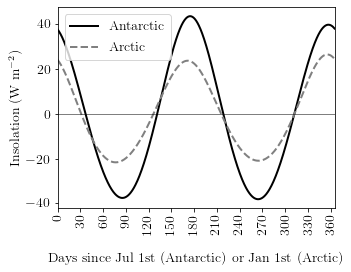

In [11]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(1,1,1)
for h in [1,0]:
    S = [nh,sh][h].interp(lat=-64.5).values
                 
    S1 = np.real(af.get_annual_harmonic(sh.day.values/len(sh.day),S))
    T, T1 = vsimplemodel(S), vsimplemodel(S1) 

                 
    for mydata in [S,T]:
        a = asym_workaround(mydata)
        print(['Arctic','Antarctic'][h]+' solar asymmetry {:0.2f} days'.format(a))
        
    label='$S-S_1$'
    ax.plot(np.linspace(1,366,len(S[:-1])),(S-S1)[:-1],label=['Arctic','Antarctic'][h],
            c=['grey','k'][h], linewidth=2, linestyle=['--','-'][h])
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Insolation (W m$^{-2}$)')
ax.axhline(y=0,c='k',linewidth=.5)
ax.set_xlim([1,366])
ax.set_xticks(np.arange(1,366,30))
ax.set_xticklabels(np.arange(0,365,30),rotation='vertical')
ax.set_xlabel('Days since Jul 1st (Antarctic) or Jan 1st (Arctic)',labelpad=15)
plt.tight_layout()
plt.show()
fig.savefig('figs/solar_NHSH.pdf',bbox_inches='tight',dpi=300)
plt.close()

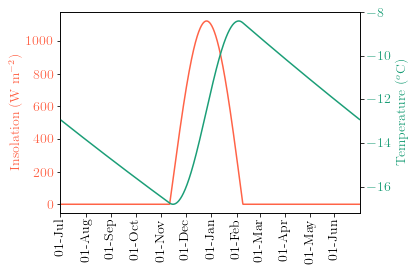

In [13]:
Sc = np.load('cartoon_solar.npy')

fig = plt.figure(figsize=(6,4))
colours = ['#1b9e77','tomato']
ax = plt.subplot(1,1,1)

ax.set_xlabel('')
ax.plot(np.linspace(1,366,len(Sc)),Sc,c=colours[1])
ax.set_ylabel('Insolation (W m$^{-2}$)',c=colours[1])
ax.tick_params(axis='y',labelcolor=colours[1])

T = vsimplemodel(Sc)

ax2 = ax.twinx()
ax2.plot(np.linspace(1,366,len(Sc)),T,c=colours[0])
ax2.set_ylabel('Temperature ($^{o}$C)',c=colours[0])
ax2.tick_params(axis='y',labelcolor=colours[0])

ax.set_xlim([1,366])
ax.set_xticks(af.shfirstofmonthind )
ax.set_xticklabels(af.shfirstofmonthlabel,rotation='vertical')

plt.tight_layout()
plt.show()
fig.savefig('figs/cartoon.pdf',bbox_inches='tight',dpi=300)
plt.close()